In [1]:
# Analyse van +5000 IMDB geregistreerde films voor data mining

# 0: color, 1: director_name, 2: num_critic_for_reviews, 3: duration, 4: director_facebook_likes, 5: actor_3_facebook_likes, 
# 6: actor_2_name, 7: actor_1_facebook_likes, 8: gross, 9: genres, 10: actor_1_name, 11: movie_title, 12: num_voted_users, 
# 13: cast_total_facebook_likes, 14: actor_3_name, 15: facenumber_in_poster, 16: plot_keywords, 17: movie_imdb_link, 
# 18: num_user_for_reviews, 19: language, 20: country, 21: content_rating, 22: budget, 23: title_year,
# 24: actor_2_facebook_likes, 25: imdb_score, 26: aspect_ratio, 27: movie_facebook_likes
# pip install geonamescache

from pyspark.sql import SQLContext
from pyspark.sql.types import *
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


raw_movie_data = sc.textFile('./movie_metadata.csv')
print raw_movie_data.count()

5044


In [2]:
raw_movie_data.take(2)

[u'color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes',
 u'Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar\xa0,886204,4834,Wes Studi,0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000']

In [3]:
header = raw_movie_data.first() #extract header
raw_movie_data = raw_movie_data.filter(lambda x: x != header)

In [4]:
movie_data = raw_movie_data.map(lambda x: x.split(","))
genre_data = movie_data.map(lambda x: x[9]).map(lambda x: x.split('|'))
counter_genres = genre_data.map(Counter).reduce(lambda x, y: x + y)
print(counter_genres)

Counter({u'Drama': 2594, u'Comedy': 1872, u'Thriller': 1411, u'Action': 1153, u'Romance': 1107, u'Adventure': 923, u'Crime': 889, u'Sci-Fi': 616, u'Fantasy': 610, u'Horror': 565, u'Family': 546, u'Mystery': 500, u'Biography': 293, u'Animation': 242, u'Music': 214, u'War': 213, u'History': 207, u'Sport': 182, u'Musical': 132, u'Documentary': 121, u'Western': 97, u'Film-Noir': 6, u'Short': 5, u'News': 3, u'Reality-TV': 2, u'Game-Show': 1})


In [5]:
def split_counter(c):
    c = c.most_common()
    c_key = []
    c_value = []
    for a, b in c:
        c_key.append(str(a))
        c_value.append(b)
    
    return c_key, c_value

In [6]:
genres, g_amount = split_counter(counter_genres)

In [7]:
def make_percentile(elems, total):
    for i, a in enumerate(elems):
        a = float(a) / float(total)
        elems[i] = a * 100
    
    return elems

In [8]:
g_amount = make_percentile(g_amount, movie_data.count())

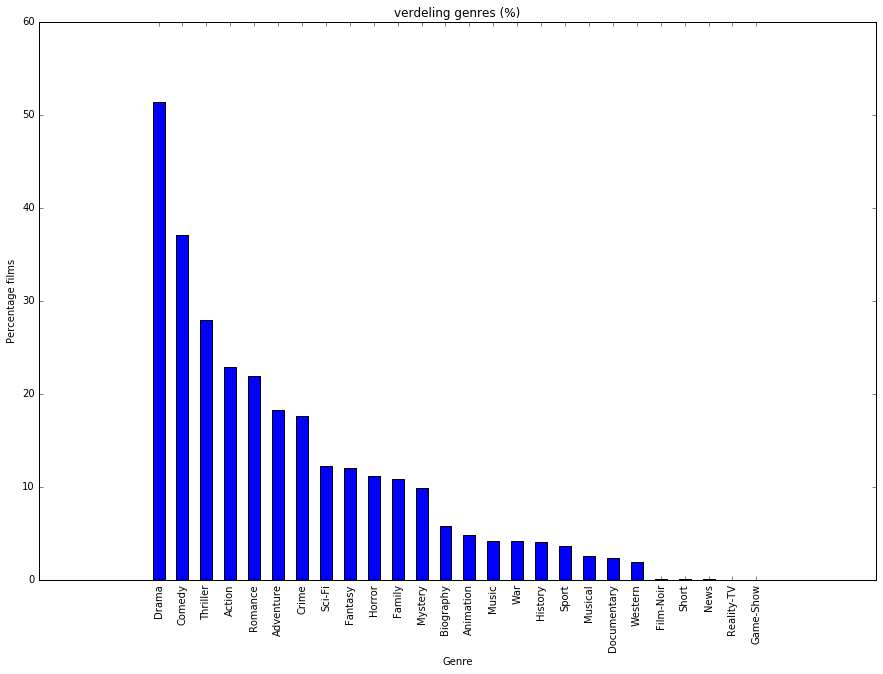

In [9]:
# alle genres met % voorkomen - barplot
%matplotlib inline
y = g_amount
x = np.arange(len(g_amount))
labels = genres

fig = plt.figure(figsize=(15, 10))
plt.title("verdeling genres (%)")
plt.bar(x,y,width=0.5,color="blue",align="center")
plt.xticks(x , labels, rotation=90, fontsize=10)
plt.ylabel("Percentage films")
plt.xlabel("Genre")
plt.show()

pass

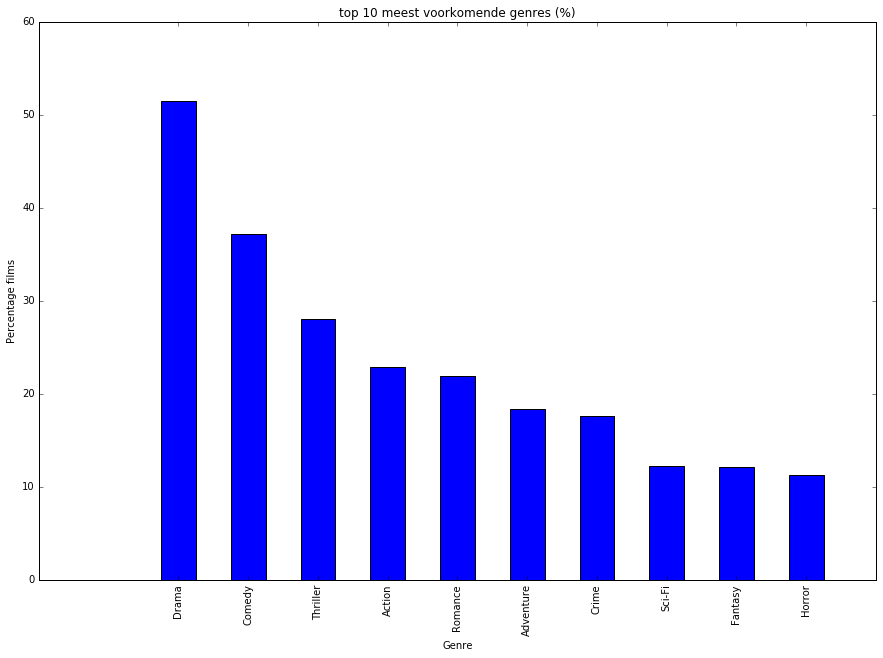

In [10]:
%matplotlib inline
y = g_amount[:10]
x = np.arange(10)
labels = genres[:10]

fig = plt.figure(figsize=(15, 10))
plt.title("top 10 meest voorkomende genres (%)")
plt.bar(x,y,width=0.5,color="blue",align="center")
plt.xticks(x , labels, rotation=90, fontsize=10)
plt.ylabel("Percentage films")
plt.xlabel("Genre")
plt.show()

pass

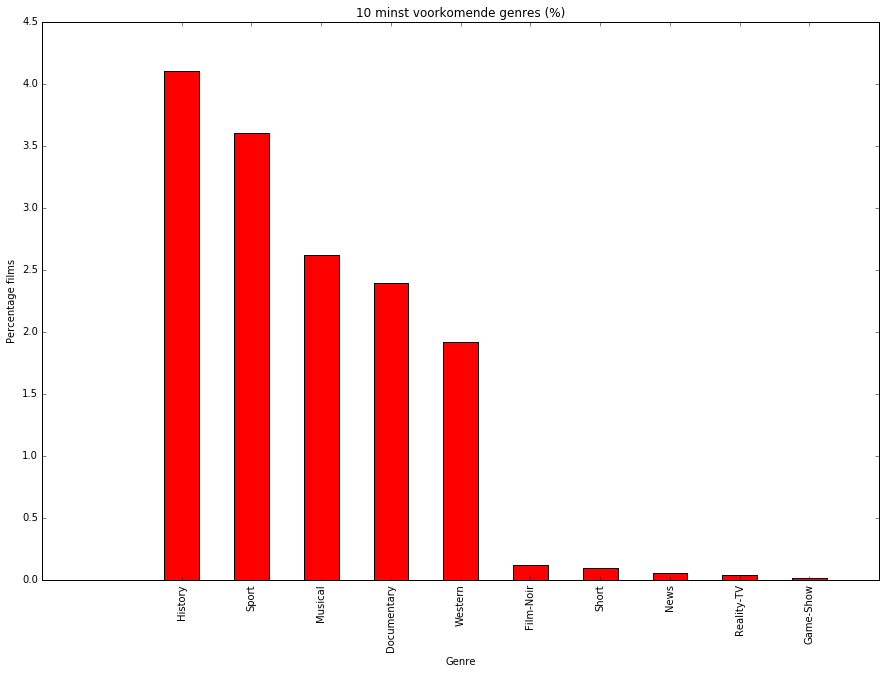

In [11]:
%matplotlib inline
y = g_amount[-10:]
x = np.arange(10)
labels = genres[-10:]

fig = plt.figure(figsize=(15, 10))
plt.title("10 minst voorkomende genres (%)")
plt.bar(x,y,width=0.5,color="red",align="center")
plt.xticks(x , labels, rotation=90, fontsize=10)
plt.ylabel("Percentage films")
plt.xlabel("Genre")
plt.show()

pass

In [12]:
imdb_genre = (movie_data
              .sortBy(lambda x: x[25], ascending = False)
              .filter(lambda x: float(x[25]) < 10.0)
              .map(lambda x: x[9])
              .take(50))

imdb_genre = sc.parallelize(imdb_genre)
imdb_genre = imdb_genre.map(lambda x: x.split('|'))
imdb_genre_counter = imdb_genre.map(Counter).reduce(lambda x, y: x + y)

print(imdb_genre_counter)

Counter({u'Drama': 36, u'Crime': 17, u'Action': 16, u'Thriller': 12, u'Adventure': 11, u'Fantasy': 7, u'Sci-Fi': 6, u'Comedy': 6, u'Family': 5, u'Mystery': 4, u'Biography': 4, u'Romance': 3, u'Horror': 3, u'History': 3, u'War': 2, u'Sport': 1, u'Western': 1, u'Animation': 1, u'Documentary': 1})


In [13]:
i_genres, ig_amount = split_counter(imdb_genre_counter)

In [14]:
ig_amount_perc = make_percentile(ig_amount, 50)

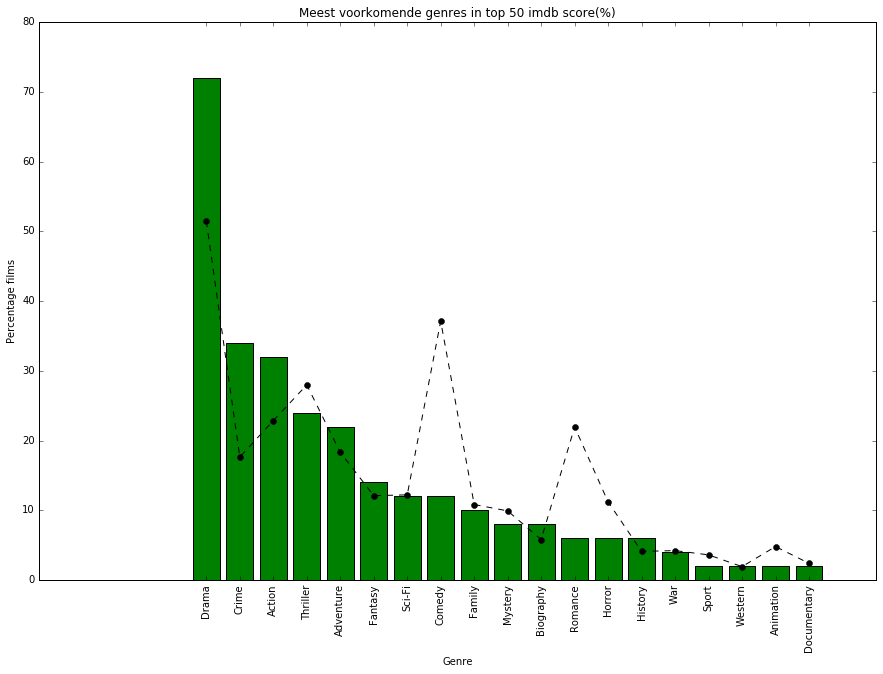

In [15]:
%matplotlib inline
y = ig_amount_perc
x = np.arange(len(ig_amount_perc))
labels = i_genres

ig_global = []
for g in i_genres:
    ig_global.append(counter_genres[str(g)])
ig_global = make_percentile(ig_global, movie_data.count())


fig = plt.figure(figsize=(15, 10))
plt.title("Meest voorkomende genres in top 50 imdb score(%)")
plt.bar(x,y,color="green",align="center")
plt.plot(x,ig_global, color='black',linestyle='dashed',marker='o')
plt.xticks(x , labels, rotation=90, fontsize=10)
plt.ylabel("Percentage films")
plt.xlabel("Genre")
plt.show()

pass
# geen music, musical, film-noir, short, news, reality, game-show

In [16]:
music_movies = movie_data.filter(lambda x: 'Music' in x[9]).filter(lambda x: 'Musical' not in x[9])
music_movies.map(lambda x: x[11].encode('ascii','ignore')).take(5)

['Home on the Range',
 'Alvin and the Chipmunks: The Road Chip',
 'Happy Feet',
 'Alvin and the Chipmunks: Chipwrecked',
 'Fantasia 2000']

In [17]:
# movie_imdb_countries = movie_data.map(lambda x: [x[20].encode('ascii','ignore'),float(x[25])])
# movies = movie_imdb_countries.countByValue()

In [18]:
movie_countries = movie_data.map(lambda x: x[20].encode('ascii','ignore'))
movie_countries = movie_countries.filter(lambda x: 'http' not in x)
movies = movie_countries.countByValue()
print (movies)

defaultdict(<type 'int'>, {'': 5, 'Canada': 123, 'Italy': 21, 'Czech Republic': 3, 'USA': 3763, 'Afghanistan': 1, 'Romanian': 1, 'Panama': 1, 'Thailand': 5, 'Cambodia': 1, 'France': 153, 'Bahamas': 1, 'West Germany': 3, 'Georgia': 1, 'Aruba': 1, 'Hindi': 1, 'Ireland': 12, 'Mandarin': 3, 'Nigeria': 1, '5': 1, 'Norway': 8, 'Argentina': 4, 'Kenya': 1, 'Spanish': 1, 'Slovakia': 1, 'Australia': 53, 'Iran': 4, 'Iceland': 3, 'Japan': 23, 'French': 1, 'Official site': 1, 'New Line': 1, 'Slovenia': 1, 'China': 28, 'Chile': 1, 'Belgium': 4, 'Germany': 96, 'Dominican Republic': 1, 'Bulgaria': 1, 'Hong Kong': 17, 'Poland': 5, 'Spain': 33, 'Kyrgyzstan': 1, 'Netherlands': 5, '143': 1, 'Libya': 1, 'Taiwan': 1, 'Denmark': 11, 'Turkey': 1, 'Indonesia': 1, 'Israel': 4, 'Cameroon': 1, 'Philippines': 1, 'Sweden': 6, '74': 1, 'Finland': 1, 'English': 50, 'Switzerland': 3, 'Italian': 2, 'New Zealand': 15, '95': 1, 'Russia': 11, 'Brazil': 8, 'Soviet Union': 1, 'Pakistan': 1, 'Romania': 3, 'Colombia': 1, 'Mex

In [19]:
# def unfuck_rdd(line):
#     if line[11] is '' or line[25] is '' or line[9] is '' or line[20] is '' or line[22] is '' or line[8] is '':
#         line[11] = 'invalid'
#         return line
#     else:
#         return([line[11].encode('ascii','ignore'), float(line[25]),line[9],line[20],
#                                      float(line[22]),float(line[8]),(float(line[22])-float(line[8])),
#                                      ((float(line[22])-float(line[8]))/float(line[22]))])

# roi_data = movie_data.map(unfuck_rdd)
# roi_data.count()

In [34]:
def add_columns(line):
    try:
        profit = float(line[7]) - float(line[6])
        roi = profit / float(line[7])
    except:
        profit = 'nope'
        roi = 'nope'
    line.append(profit)
    line.append(roi)
    return line

unfucked_rdd = movie_data.map(lambda x: [x[11],x[25],x[9],x[20],x[16],x[1],x[22],x[8]])
new_rdd = unfucked_rdd.map(add_columns)
new_rdd = new_rdd.filter(lambda x: x[8] is not 'nope')
new_rdd.take(5)

[[u'Avatar\xa0',
  u'7.9',
  u'Action|Adventure|Fantasy|Sci-Fi',
  u'USA',
  u'avatar|future|marine|native|paraplegic',
  u'James Cameron',
  u'237000000',
  u'760505847',
  523505847.0,
  0.6883653150927057],
 [u"Pirates of the Caribbean: At World's End\xa0",
  u'7.1',
  u'Action|Adventure|Fantasy',
  u'USA',
  u'goddess|marriage ceremony|marriage proposal|pirate|singapore',
  u'Gore Verbinski',
  u'300000000',
  u'309404152',
  9404152.0,
  0.030394394965973178],
 [u'Spectre\xa0',
  u'6.8',
  u'Action|Adventure|Thriller',
  u'UK',
  u'bomb|espionage|sequel|spy|terrorist',
  u'Sam Mendes',
  u'245000000',
  u'200074175',
  -44925825.0,
  -0.22454584655915738],
 [u'The Dark Knight Rises\xa0',
  u'8.5',
  u'Action|Thriller',
  u'USA',
  u'deception|imprisonment|lawlessness|police officer|terrorist plot',
  u'Christopher Nolan',
  u'250000000',
  u'448130642',
  198130642.0,
  0.44212696796573886],
 [u'John Carter\xa0',
  u'6.6',
  u'Action|Adventure|Sci-Fi',
  u'USA',
  u'alien|american